In [1]:
import scipy.special as sp
import scipy.integrate as intg
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mpc
from mpmath import mp
import mpmath

## LG-Beam class
### $\mathbf{E} = \frac{1}{2}\mathbf{E}_{pl, 0}(\alpha, \beta) + \frac{1}{4} \mathbf{E}_{pl, -2}(\alpha + i\beta, i\alpha - \beta) + \frac{1}{4} \mathbf{E}_{pl, 2}(\alpha - i\beta, -i\alpha - \beta)$

In [13]:
class LGBeam:
    p, l = 0, 2
    alpha, beta = 1, 0
    r_focus = 1E-3
    wavelength = 6238E-9
    na = .95
    k = 2 * np.pi / wavelength
    w0 = 3.2 * wavelength
    s = 1 / k / w0
        
    
    def __init__(self, *args, **kwargs):
        if kwargs:
            self.p = kwargs["p"]
            self.l = kwargs["l"]
            self.alpha = kwargs["alpha"]
            self.beta = kwargs["beta"]
            self.r_focus = kwargs["r_focus"]
            self.na = kwargs["na"]
            self.wavelength = kwargs["wavelength"]
        
        self.k = 2 * np.pi / self.wavelength
        self.w0 = 3.2 * self.wavelength
        self.s = 1 / self.k / self.w0
        
    def a(self, u):
        return self.r_focus * self.s * np.sqrt(2) * u
    
    def e_integrand_in(self, u, q):
        kz = mpmath.sqrt(self.k ** 2 - u ** 2)
        a = self.a
        result = u / mpmath.sqrt(self.k * kz) \
               * (1 + (1 - np.abs(q)) * kz / self.k) \
               * -1 ** self.p / self.w0 \
               * np.sqrt(2 / mpmath.pi * mpmath.gammaprod([self.p + 1],
                                         [self.p + np.abs(self.l) + 1])) \
               * a(u) ** np.abs(self.l) \
               * mpmath.laguerre(self.p, self.l, a(u) ** 2) \
               * mpmath.exp(-a(u) ** 2 / 2)
        return result
    
    def e_integrand(self, u, q, alpha, beta, r, theta, phi):
        kz = mpmath.sqrt(mpmath.power(self.k, 2) - mpmath.power(u, 2))
        result = self.e_integrand_in(u, q) \
               * mpmath.exp(1j * (self.l + q) * phi \
                          + 1j * kz * r * np.cos(theta)) \
               * ((alpha * np.cos(phi) + beta * np.sin(phi)) 
                 * np.sin(theta) \
                 * mpmath.besselj(self.l + q, r * np.sin(theta) * u) \
                 + u * np.cos(theta) / 2 / kz \
                 * ((1j * alpha - beta) * np.exp(-1j * phi) \
                   * mpmath.besselj(self.l + q - 1, r * np.sin(theta) * u) \
                   - (1j * alpha + beta) * np.exp(1j * phi) \
                   * mpmath.besselj(self.l + q + 1, r * np.sin(theta) * u)))
        return result
    
    def e_mode(self, q, new_alpha, new_beta, r, theta, phi):
        return intg.romberg(self.e_integrand,
                            0, self.k * self.na,
                            args=(q, new_alpha, new_beta, r, theta, phi))
    
    def eta_integrand(self, u, *coords):
        a, b = self.alpha, self.beta
        return lgbeam.e_integrand(u, 0, a, b, *coords) / 2 \
            + lgbeam.e_integrand(u, -2, a + 1j * b, 1j * a - b, *coords) / 4 \
            + lgbeam.e_integrand(u, 2, a - 1j * b, -1j * a - b, *coords) / 4

    def triple_integrand(self, u, theta, phi, n, m):
        return self.eta_integrand(u, (n + .5) / self.k, theta, phi) \
            * sp.lpmv(np.abs(m), n, np.cos(theta)) \
            * np.exp(-1j * m * phi) * mpmath.sin(theta)
    
    def real_triple_integrand(self, *args, **kwargs):
        return mpmath.re(self.triple_integrand(*args, **kwargs))
    
    def imag_triple_integrand(self, *args, **kwargs):
        return mpmath.im(self.triple_integrand(*args, **kwargs))
            
    def real_triple_integral(self, n, m):
        return intg.tplquad(self.real_triple_integrand,
                            0, np.pi, 0, 2 * np.pi, 0, self.k * self.na,
                            args=(n, m))
    def imag_triple_integral(self, n, m):
        return intg.tplquad(self.imag_triple_integrand,
                            0, np.pi, 0, 2 * np.pi, 0, self.k * self.na,
                            args=(n, m))
    
    def triple_integral(self, n, m):
        return self.real_triple_integral(n, m) \
            + 1j * self.imag_triple_integral(n, m)
    
    def field(self, r, theta, phi):
        a, b = self.alpha, self.beta
        
        result = self.e_mode(0, a, b, r, theta, phi) / 2 \
               + self.e_mode(-2, a + 1j * b, 1j * a - b, r, theta, phi)/ 4 \
               + self.e_mode(2, a - 1j * b, -1j * a - b, r, theta, phi) / 2
        return result

lgbeam = LGBeam()
print(lgbeam.triple_integral(3, 1))

TypeError: can't multiply sequence by non-int of type 'complex'

## Integrand
### $\mathcal{I}(\theta, \phi) = E_r(kr = R^\text{loc}, \theta, \phi) P_n^{|m|}(\cos\theta)e^{-im\phi}\sin\theta$
## Triple integrand
### $I(\eta, \theta, \phi) = E_0 \frac{\eta^{|l|+1}}{\sqrt{\sqrt{k^2 - \eta^2}}} L_p^l(b(\eta))\exp(-c(\eta))e^{i(l-1)\phi} e^{i\sqrt{k^2 - \eta^2}r\cos\theta} \times \ldots$

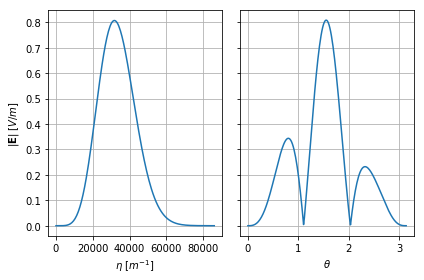

In [165]:
lgbeam = LGBeam()
n = lgbeam.l + 1
m = lgbeam.l - 1
r = (n + 1 / 2) / lgbeam.k
theta = np.pi / 2
phi = .15 * np.pi

# fld = lgbeam.field(r, theta, phi)
# dbl_integrand = fld * sp.lpmv(np.abs(m), n, np.cos(theta)) * np.exp(-1j * m * phi)
# print(mpmath.norm(dbl_integrand))
coords = r, theta, phi

def eta_integrand(u, *coords, lgbeam=lgbeam):
    a, b = lgbeam.alpha, lgbeam.beta
    return lgbeam.e_integrand(u, 0, a, b, *coords) / 2 \
        + lgbeam.e_integrand(u, -2, a + 1j * b, 1j * a - b, *coords) / 4 \
        + lgbeam.e_integrand(u, 2, a - 1j * b, -1j * a - b, *coords) / 4

def triple_integrand(u, n, m, r, theta, phi, lgbeam=lgbeam):
    return eta_integrand(u, r, theta, phi, lgbeam=lgbeam) \
        * sp.lpmv(np.abs(m), n, np.cos(theta)) \
        * np.exp(-1j * m * phi) * mpmath.sin(theta)

delta = .09
max_u = lgbeam.k * lgbeam.na * delta
us = np.linspace(0, max_u, 200)
ts = np.linspace(0, np.pi, 200)
fig, axes = plt.subplots(ncols=2, sharey=True)

ints = []
max_val = 0
peak_u = 0
for u in us:
    val = mpmath.norm(triple_integrand(u, n, m, *coords))
    if val >= max_val:
        max_val = val
        peak_u = u
    ints.append(val)

ints2 = []
for t in ts:
    val = mpmath.norm(triple_integrand(peak_u, n, m, r, t, phi))
    ints2.append(val)
    
axes[0].grid()
axes[1].grid()
axes[0].set_xlabel("$\\eta\\ [m^{-1}]$")
axes[0].set_ylabel("$|\\mathbf{E}|\\ [V / m]$")
axes[0].plot(us, ints)
axes[1].set_xlabel("$\\theta$")
axes[1].plot(ts, ints2)
plt.show()

In [133]:
delta = .09
max_u = lgbeam.k * lgbeam.na * delta
us = np.linspace(0, max_u, 200)
ts = np.linspace(0, np.pi, 100)
uu, tt = np.meshgrid(us, ts)

def tinteg(u, t):
    return float(mpmath.norm(triple_integrand(u, n , m, r, t, phi)))
tinteg = np.frompyfunc(tinteg, 2, 1)

integrand = tinteg(uu, tt)

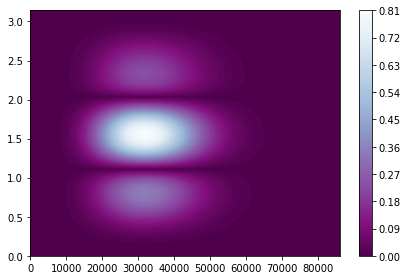

In [134]:
cname = "BuPu_r"

plt.contourf(us, ts, integrand, 100, cmap=cname)
plt.colorbar()
plt.show()

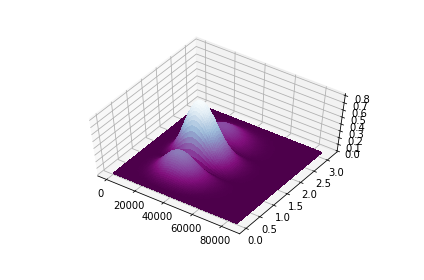

In [135]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import rcParams
rcParams.update({"figure.autolayout": True})

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(uu, tt, integrand, cmap='BuPu_r',
                rcount=100, ccount=100, shade=True,
                linewidth=0, antialiased=False)
# plt.show()
ax.view_init(60, -55)
ax.dist = 13
#plt.tight_layout()
# plt.colorbar(ax)
plt.show()

In [ ]:
# LG parameters:

parameters = {
    "p": 0,
    "l": 2,
    "alpha": 1,
    "beta": 0,
    "r_focus": 1E-3,
    "wavelength": 6328E-9,
    "na": .95
}

parameters["k"] = 2 * np.pi / parameters["wavelength"]
parameters["s"] = 3.2 * parameters["wavelength"]

In [ ]:
## Electric field:


def e_radial(lgbeam):
    e(p, l, 0, alpha=lgbeam.alpha, beta=lgbeam.beta)

In [ ]:
## test Romberg integration

def f(x, a, b):
    return a * x + b




In [8]:
mpmath.im(1j)

mpf('1.0')